In [3]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
from  lectures.micrograd.plot_graph import draw_dot

%matplotlib inline

In [4]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out
        
    def __rsub__ (self, other):
        return self + (-other)
    
    def __mul__(self, other):
        # This will only work a * 2 and fail for 2 * a. This is fixed by __rmul__
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)) # can only have numbers 
        x = self.data
        out = Value(x**other, (self,), f'**{other}')
        def _backward():
            self.grad +=  other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out 
    # Need to solve the opposite case 2 * a
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __radd__ (self, other):
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.grad * out.data

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [5]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# When you call this expression, the _backward method is now not None anymore. It  is set to the function as described in the tanh() method, which is the gradient of the tanh function, which can be e
o = n.tanh(); o.label = 'o'
o.backward()

In [6]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()

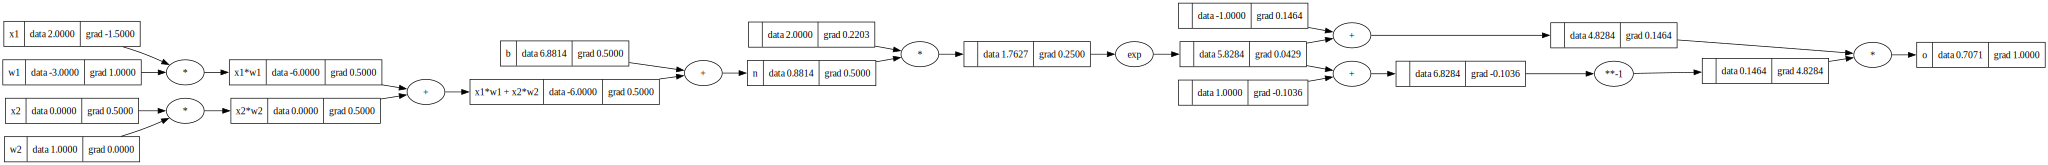

In [7]:
draw_dot(o)

Scratch Testing

In [8]:
a = Value(2.0)
b = Value(4.0)

In [9]:
2* a

Value(data=4.0, grad=0.0)

In [10]:
import torch

In [11]:
torch.Tensor([[2,3,4], [5, 6.0, 7]])

tensor([[2., 3., 4.],
        [5., 6., 7.]])

In [12]:
# python floats defaults to double precision (float64). sys.float_info shows attributes like mant_dig=53 and epsilon=2.220446049250313e-16, which are characteristic of IEEE 754 double precision.
import sys
sys.float_info
# pytorch tensor defaults to single precision (float32). It explicitly needs to be specified to be double if required.
print(torch.Tensor([2.0]).dtype)
x1 = torch.Tensor([2.0]).double() 
# By default pytorch does not assign grad for leaf nodes. To be consistent with micrograd we specify that these leaf nodes also needs to have gradients
x1.requires_grad = True

x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) # can be o.item() as well
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

torch.float32
0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [13]:
print(x2.data)
print(x2.grad)

tensor([0.], dtype=torch.float64)
tensor([0.5000], dtype=torch.float64)


In [14]:
from typing import Any, List


class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x:List[float]):
    # Forward Pass
    act = sum((xi*wi for xi, wi in zip(x, self.w)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]
  
class Layer:

  def __init__(self, nin, nout) -> None:
    # Create a list of Neurons of length nout
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [ p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin: int, nouts: List[int]):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self,x: List[float]):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

  

In [15]:
# # Test only a Neuron
# x = [2.0, 3.0]
# nin = 2
# nout = 3
# n = Neuron(2)
# n(x)

In [16]:
# # Test a single layer
# x = [2.0, 3.0]
# n = Layer(2,3)
# n(x)

In [17]:
# Test a 3 layer MLP
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.43554653899065343, grad=0.0)

In [18]:
len(n.parameters())

41

In [19]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [24]:
n.layers[0].neurons[0].w

[Value(data=-0.37621368616571726, grad=0.0),
 Value(data=0.43996725732787256, grad=0.0),
 Value(data=-0.8864599252706957, grad=0.0)]

In [26]:
# A single number to calculate performance of neural net
for k in range(1000):
    # How to do adaptive learning rate
    learning_rate = -0.05
    # forward pass
    # If the dataset is big, we need to process in batch and not the full dataset
    y_pred = [n(x) for x in xs]
    # print(y_pred)
    # How to do more complex loss functions?
    loss = sum((yout-ygt)**2 for yout, ygt in zip(y_pred, ys))
    # print(loss)

    # backward pass
    # Flush your gradients. Otherwise your gradients will accumulated
    # It might work in some scenarios, but that is the unfortunate way in AI where for some subset of problems it can work even with the wrong approach / algorithm.
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    for p in n.parameters():
        p.data += learning_rate * p.grad
    
    print(k, loss)



0 Value(data=0.0008067553916745238, grad=1.0)
1 Value(data=0.0008051308782411286, grad=1.0)
2 Value(data=0.0008035128529037367, grad=1.0)
3 Value(data=0.0008019012769963161, grad=1.0)
4 Value(data=0.0008002961121587931, grad=1.0)
5 Value(data=0.0007986973203340902, grad=1.0)
6 Value(data=0.0007971048637651, grad=1.0)
7 Value(data=0.0007955187049917699, grad=1.0)
8 Value(data=0.0007939388068481661, grad=1.0)
9 Value(data=0.0007923651324596183, grad=1.0)
10 Value(data=0.0007907976452398569, grad=1.0)
11 Value(data=0.0007892363088882285, grad=1.0)
12 Value(data=0.0007876810873868977, grad=1.0)
13 Value(data=0.0007861319449981033, grad=1.0)
14 Value(data=0.0007845888462614482, grad=1.0)
15 Value(data=0.0007830517559912246, grad=1.0)
16 Value(data=0.0007815206392737754, grad=1.0)
17 Value(data=0.0007799954614648231, grad=1.0)
18 Value(data=0.000778476188186946, grad=1.0)
19 Value(data=0.0007769627853269668, grad=1.0)
20 Value(data=0.0007754552190334351, grad=1.0)
21 Value(data=0.00077395345

In [25]:
y_pred

[Value(data=0.9836408294337331, grad=-0.0327183411325338),
 Value(data=-0.9918182178915362, grad=0.01636356421692753),
 Value(data=-0.9833497355863317, grad=0.033300528827336695),
 Value(data=0.9859789049269556, grad=-0.028042190146088775)]

In [ ]:
# How to register a new type of activation in Pytorch?